In [1]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

print("Starting Notebook.")

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")

Starting Notebook.


## Loading Data

In [2]:
SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 
           'JFrog', 'Jira', 'JiraEcosystem', 
           'MariaDB', 'MongoDB', 'Qt', 
           'RedHat', 'Sakai', 'SecondLife', 
           'Sonatype', 'Spring']
# 'Mindville'

CONFIG = ['R_LTvNL', 'R_LTvOL', 'R_LTvNLOL', 'R_LTOLvNL']
LT = 'Duplication'

In [3]:
def print_linktypes(SOURCE):
    #Loading Issues
    filename = '../data/crawl/issues_'+SOURCE.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';')
    
    issue_set = set(issues['issue_id'])
        
    #Loading Links
    filename = '../data/crawl/clean_links_'+SOURCE.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0)
    
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    num_dups = len(links[links['linktype']=='Duplicate'])
        
    return len(issues), len(links), len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), num_dups

In [5]:
overview = pd.DataFrame(columns = ['Project', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#NumDups'])
j=0
for s in SOURCES:
    i, l, ltu, pi, nd = print_linktypes(s)
    
    if s == 'JiraEcosystem':
        s = 'JiraEco.'
    
    overview.loc[j]=[s, i, l, ltu, pi, nd]
    
    j+=1

In [6]:
overview

,Project,#Issues,#Links,#Linktypes,%IssuesWithLinks,#NumDups
0,Apache,970929,242823,21,0.283,24868
1,Hyperledger,27914,16225,8,0.551,634
2,IntelDAOS,5557,3222,10,0.555,117
3,JFrog,14769,3206,11,0.298,639
4,Jira,265343,98122,19,0.477,21350
5,JiraEco.,40602,10911,18,0.328,1721
6,MariaDB,31229,14618,8,0.445,1374
7,MongoDB,90629,37545,13,0.426,6548
8,Qt,140237,35855,8,0.289,3827
9,RedHat,315797,106200,18,0.389,5436


## Loading Model Results

In [7]:
R_LTvNL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTvOL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTvNLOL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTOLvNL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])

In [8]:
big_dict = {
    'R_LTvNL': R_LTvNL_df, 
    'R_LTvOL': R_LTvOL_df, 
    'R_LTvNLOL': R_LTvNLOL_df,  
    'R_LTOLvNL': R_LTOLvNL_df  
}

In [9]:
# SOURCES = ['qt', 'jira', 'jiraecosystem', 'mariadb', 'apache', 'mongodb']

valid_projects = []

for s in SOURCES:
    valid = True
    for c in CONFIG:
        filename = 'results/sccnn_latenight_'+s.lower()+'_'+LT+'_'+c+'_metrics.csv'
        metrics_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
        
        LT_mets = metrics_df.iloc[0].values.tolist()[1:]
        NL_mets = metrics_df.iloc[1].values.tolist()[1:]
        OL_mets = metrics_df.iloc[2].values.tolist()[1:]
#         Both_mets = metrics_df.iloc[3].values.tolist()[1:]
        macro_pre = metrics_df['Precision'].iloc[0:3].sum()/3
        macro_rec = metrics_df['Recall'].iloc[0:3].sum()/3
        macro_f1 = metrics_df['F1'].iloc[0:3].sum()/3
        macro_mets = [macro_pre, macro_rec, macro_f1]
        
        filename = 'results/sccnn_latenight_'+s.lower()+'_'+LT+'_'+c+'_accauc.csv'
        accauc_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
        
        accauc = accauc_df.iloc[0].values.tolist()[1:]
        
#         filename = 'results/'+s+'_'+LT+'_'+c+'_confmat.csv'
#         confmat = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
    
        temp_df = big_dict[c]
        
        if s == 'JiraEcosystem':
            temp_row = ['JiraEco.'] + LT_mets + OL_mets + NL_mets + macro_mets + accauc
        else:
            temp_row = [s] + LT_mets + OL_mets + NL_mets + macro_mets + accauc
        
        valid = valid and not(np.isnan(LT_mets + OL_mets + NL_mets).any())
          
        temp_df.loc[len(temp_df)] = temp_row
    if valid:
        if s == 'JiraEcosystem':
            valid_projects.append('JiraEco.')
        else:
            valid_projects.append(s)

In [10]:
valid_projects

['Apache',
 'Hyperledger',
 'IntelDAOS',
 'JFrog',
 'Jira',
 'JiraEco.',
 'MariaDB',
 'MongoDB',
 'Qt',
 'RedHat',
 'Sakai',
 'Sonatype',
 'Spring']

# Figures

In [11]:
temp_df1 = R_LTvNL_df[['Project', 'macro_f1']]
temp_df1['dataset'] = 'DvNL'
temp_df2 = R_LTvOL_df[['Project', 'macro_f1']]
temp_df2['dataset'] = 'DvOL'
temp_df3 = R_LTvNLOL_df[['Project', 'macro_f1']]
temp_df3['dataset'] = 'DvNLOL'
temp_df4 = R_LTOLvNL_df[['Project', 'macro_f1']]
temp_df4['dataset'] = 'DOLvNL'

<ipython-input-11-9ab82b36f127>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1['dataset'] = 'DvNL'
<ipython-input-11-9ab82b36f127>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['dataset'] = 'DvOL'
<ipython-input-11-9ab82b36f127>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [12]:
frames = [temp_df1, temp_df2, temp_df3, temp_df4]

tidy_df = pd.concat(frames, sort=False)

In [13]:
project_order = overview.sort_values(by=['#Links'], ascending=False)['Project'].values.tolist()

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

project_list = intersection(project_order, valid_projects)

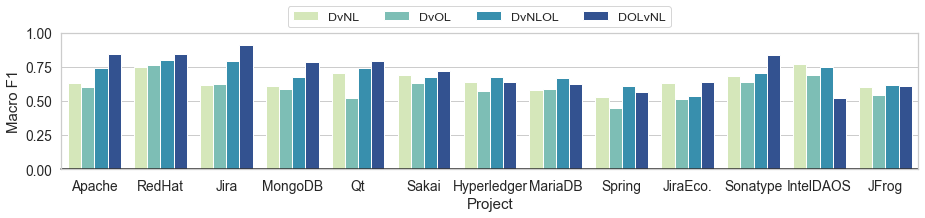

In [21]:
f, ax = plt.subplots(1, 1, figsize=(13, 3), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(12, 5)

# plt.xticks(rotation=90)
ax = sns.barplot(x='Project', y='macro_f1', hue ='dataset', data=tidy_df, order=project_list, ax=ax, palette="YlGnBu")
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Macro F1")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(-0.275, 1.05, 1, 0), ncol=4, fontsize='small')

ax.legend([],[], frameon=False)

ax.set(ylim=(0, 1))
fig.tight_layout()        

fig.savefig('results/SCCNN_f1.png', dpi = 300, bbox_inches='tight')


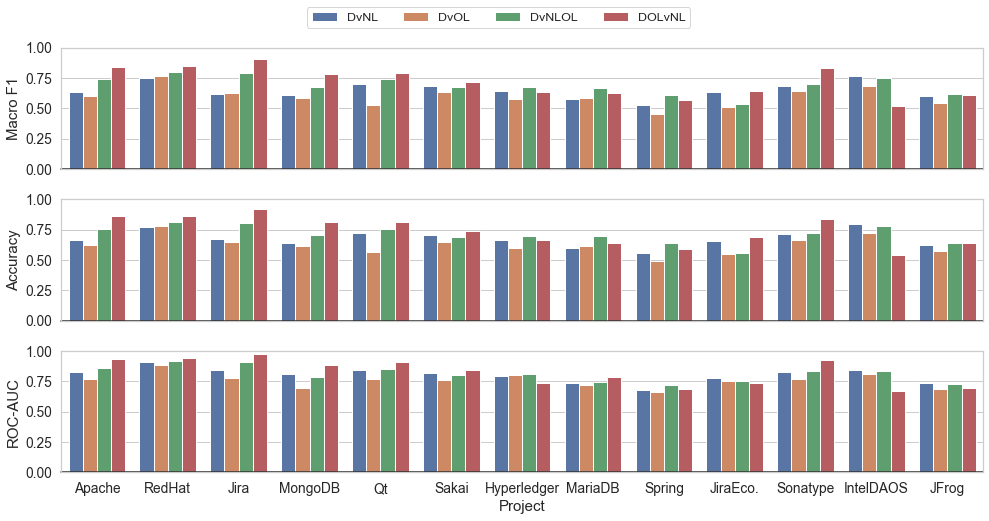

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(12, 5)

# plt.xticks(rotation=90)
ax1 = sns.barplot(x='Project', y='macro_f1', hue ='dataset', data=tidy_df, order=project_list, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Macro F1")

ax1.legend([],[], frameon=False)
ax1.set(xlabel=None)

ax2 = sns.barplot(x='Project', y='Acc', hue ='dataset', data=tidy_df, order=project_list, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Accuracy")
# ax2._legend.remove()

ax2.legend([],[], frameon=False)
ax2.set(xlabel=None)

ax3 = sns.barplot(x='Project', y='Auc', hue ='dataset', data=tidy_df, order=project_list, ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("ROC-AUC")

ax3.legend([],[], frameon=False)

ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))
ax3.set(ylim=(0, 1))
       
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(-0.3, 1.05, 1, 0), ncol=4, fontsize='small')


fig.tight_layout()      
        
fig.savefig('results/SCCNN_all_1.png', dpi = 300, bbox_inches='tight')


# Statistical Significances

In [17]:
temp1 = big_dict['R_LTvNL']
temp2 = big_dict['R_LTOLvNL']

temp1 = temp1[temp1['Project'].isin(valid_projects)]
temp2 = temp2[temp2['Project'].isin(valid_projects)]

acc1 = temp1["Acc"]
acc2 = temp2["Acc"]

auc1 = temp1["Auc"]
auc2 = temp2["Auc"]

mf1 = temp1["macro_f1"]
mf2 = temp2["macro_f1"]

mp1 = temp1["macrco_pre"]
mp2 = temp2["macrco_pre"]

mr1 = temp1["macro_rec"]
mr2 = temp2["macro_rec"]

In [18]:
print(temp1.describe())
print(temp2.describe())

          LT_pre     LT_rec      LT_f1     OL_pre     OL_rec      OL_f1  \
count  13.000000  13.000000  13.000000  13.000000  13.000000  13.000000   
mean    0.515184   0.854381   0.639354   0.752580   0.425165   0.522189   
std     0.068804   0.072231   0.054016   0.063643   0.177049   0.142684   
min     0.415094   0.754717   0.549472   0.633333   0.151496   0.256510   
25%     0.476599   0.788512   0.604000   0.702532   0.323529   0.428571   
50%     0.500694   0.843636   0.651570   0.758621   0.452235   0.578867   
75%     0.544643   0.924357   0.676728   0.788083   0.502262   0.593685   
max     0.677966   0.970283   0.727192   0.863893   0.830189   0.800000   

          NL_pre     NL_rec      NL_f1  macrco_pre  macro_rec   macro_f1  \
count  13.000000  13.000000  13.000000   13.000000  13.000000  13.000000   
mean    0.832331   0.746372   0.784276    0.700032   0.675306   0.648606   
std     0.089269   0.141810   0.115325    0.061592   0.066879   0.066766   
min     0.677083   0

In [19]:
from scipy import stats

print(stats.ttest_ind(acc1, acc2, equal_var=False))
print(stats.ttest_ind(auc1, auc2, equal_var=False))
print(stats.ttest_ind(mf1, mf2, equal_var=False))

print(stats.ttest_ind(mp1, mp2, equal_var=False))
print(stats.ttest_ind(mr1, mr2, equal_var=False))

Ttest_indResult(statistic=-1.6582643480481558, pvalue=0.11392722414184785)
Ttest_indResult(statistic=-0.6331271632986846, pvalue=0.5344262478382403)
Ttest_indResult(statistic=-1.769580233423428, pvalue=0.09341576701296682)
Ttest_indResult(statistic=-0.6467096204056928, pvalue=0.5257639246623591)
Ttest_indResult(statistic=-1.6584060962443166, pvalue=0.11389822048389114)


In [20]:
mcnemar = pd.read_csv('results/mcnemar_latenight_sccnn.csv')
print(mcnemar)

       Unnamed: 0        p-value
0          apache  1.277953e-160
1          redhat   3.616937e-32
2            jira  1.379675e-218
3         mongodb   6.271946e-27
4              qt   1.834608e-10
5           sakai   7.624059e-04
6     hyperledger   1.910759e-01
7         mariadb   5.545667e-03
8          spring   1.934054e-02
9   jiraecosystem   9.482080e-14
10       sonatype   4.181220e-03
11          jfrog   1.000000e+00
12      inteldaos   9.763500e-06
13     secondlife   3.864762e-01
14      mindville            NaN


# Values for Tables

In [21]:
def add_mean(df):
    
    og_df = df[df['Project'].isin(valid_projects)]
    
    averages = og_df.mean()
    avg_row = averages.to_list()
    avg_row.insert(0, "Mean")
    
    stds = og_df.std()
    std_row = stds.to_list()
    std_row.insert(0, "Standard Dev.")
    
    df.loc[len(df)] = avg_row
    df.loc[len(df)] = std_row
    
    return df

In [22]:
add_mean(big_dict['R_LTvNL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.500694,0.934899,0.652132,0.788083,0.242225,0.370556,0.926867,0.825073,0.873013,0.738548,0.667399,0.631900,0.667473,0.824608
1,Hyperledger,0.494318,0.787330,0.607330,0.702532,0.502262,0.585752,0.765000,0.692308,0.726841,0.653950,0.660633,0.639974,0.660633,0.794056
2,IntelDAOS,0.677966,0.754717,0.714286,0.771930,0.830189,0.800000,0.767857,0.811321,0.788991,0.739251,0.798742,0.767759,0.798742,0.842293
3,JFrog,0.459091,0.765152,0.573864,0.720721,0.606061,0.658436,0.677083,0.492424,0.570175,0.618965,0.621212,0.600825,0.621212,0.734232
4,Jira,0.505467,0.970283,0.664674,0.836009,0.151496,0.256510,0.968009,0.899210,0.932342,0.769828,0.673663,0.617842,0.673663,0.845848
5,JiraEco.,0.489465,0.788512,0.604000,0.700000,0.493473,0.578867,0.763848,0.684073,0.721763,0.651105,0.655352,0.634877,0.655352,0.779356
6,MariaDB,0.446154,0.843636,0.583648,0.688406,0.345455,0.460048,0.795238,0.607273,0.688660,0.643266,0.598788,0.577452,0.598788,0.733554
7,MongoDB,0.476599,0.924357,0.628924,0.783550,0.273828,0.405830,0.903846,0.711044,0.795936,0.721332,0.636409,0.610230,0.636409,0.811799
8,Qt,0.549779,0.879906,0.676728,0.795728,0.467818,0.589224,0.871104,0.811617,0.840309,0.738870,0.719780,0.702087,0.719780,0.843092
9,RedHat,0.597518,0.928750,0.727192,0.863893,0.452235,0.593685,0.928278,0.922169,0.925213,0.796563,0.767718,0.748697,0.767718,0.907531


In [23]:
add_mean(big_dict['R_LTvOL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.465416,0.873770,0.607334,0.832685,0.628542,0.716353,0.744406,0.367639,0.492197,0.680835,0.623317,0.605295,0.623316,0.769846
1,Hyperledger,0.449339,0.923077,0.604444,0.883562,0.583710,0.702997,0.787500,0.285068,0.418605,0.706800,0.597285,0.575349,0.597285,0.798371
2,IntelDAOS,0.571429,0.679245,0.620690,0.716667,0.811321,0.761062,0.679245,0.679245,0.679245,0.655780,0.723270,0.686999,0.723270,0.807405
3,JFrog,0.430712,0.871212,0.576441,0.821053,0.590909,0.687225,0.666667,0.257576,0.371585,0.639477,0.573232,0.545083,0.573232,0.687041
4,Jira,0.486433,0.868038,0.623479,0.848701,0.740233,0.790765,0.722344,0.343308,0.465418,0.685826,0.650526,0.626554,0.650526,0.776201
5,JiraEco.,0.417946,0.924282,0.575610,0.866972,0.493473,0.628952,0.743363,0.219321,0.338710,0.676094,0.545692,0.514424,0.545692,0.750941
6,MariaDB,0.449210,0.723636,0.554318,0.706564,0.665455,0.685393,0.618090,0.447273,0.518987,0.591288,0.612121,0.586233,0.612121,0.720942
7,MongoDB,0.451568,0.740545,0.561032,0.721817,0.673222,0.696673,0.622247,0.427383,0.506726,0.598544,0.613717,0.588144,0.613717,0.694878
8,Qt,0.433274,0.950549,0.595232,0.925178,0.611460,0.736295,0.745968,0.145212,0.243101,0.701473,0.569074,0.524876,0.569074,0.764433
9,RedHat,0.616336,0.881779,0.725541,0.856513,0.705695,0.773824,0.863111,0.745405,0.799951,0.778653,0.777627,0.766439,0.777627,0.883361


In [24]:
add_mean(big_dict['R_LTvNLOL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.592805,0.856501,0.700664,0.810404,0.613683,0.698456,0.847551,0.797790,0.821918,0.750253,0.755992,0.740346,0.756016,0.862765
1,Hyperledger,0.527536,0.823529,0.643110,0.794737,0.683258,0.734793,0.766467,0.579186,0.659794,0.696247,0.695324,0.679232,0.695324,0.810211
2,IntelDAOS,0.645161,0.754717,0.695652,0.771930,0.830189,0.800000,0.754717,0.754717,0.754717,0.723936,0.779874,0.750123,0.779874,0.833749
3,JFrog,0.475962,0.750000,0.582353,0.725000,0.659091,0.690476,0.673267,0.515152,0.583691,0.624743,0.641414,0.618840,0.641414,0.724920
4,Jira,0.645237,0.913549,0.756301,0.885777,0.670407,0.763189,0.905390,0.827307,0.864589,0.812135,0.803755,0.794693,0.803755,0.906483
5,JiraEco.,0.420398,0.882507,0.569503,0.800000,0.469974,0.592105,0.727273,0.313316,0.437956,0.649224,0.555265,0.533188,0.555265,0.753480
6,MariaDB,0.536313,0.698182,0.606635,0.701439,0.709091,0.705244,0.694853,0.687273,0.691042,0.644202,0.698182,0.667640,0.698182,0.742116
7,MongoDB,0.551995,0.690620,0.613575,0.688262,0.683056,0.685649,0.709723,0.756430,0.732332,0.649994,0.710035,0.677186,0.710035,0.783942
8,Qt,0.588392,0.867347,0.701142,0.840114,0.697017,0.761905,0.839962,0.696232,0.761373,0.756156,0.753532,0.741473,0.753532,0.853921
9,RedHat,0.663444,0.887452,0.759270,0.855520,0.666440,0.749235,0.886990,0.883367,0.885175,0.801985,0.812420,0.797893,0.812420,0.914518


In [25]:
add_mean(big_dict['R_LTOLvNL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.856664,0.883440,0.869846,0.852668,0.855909,0.854285,0.765829,0.852184,0.806702,0.825054,0.863844,0.843611,0.863846,0.935686
1,Hyperledger,0.692308,0.610860,0.649038,0.704433,0.647059,0.674528,0.495385,0.728507,0.589744,0.630709,0.662142,0.637770,0.662142,0.733953
2,IntelDAOS,0.696970,0.433962,0.534884,0.666667,0.377358,0.481928,0.405660,0.811321,0.540881,0.589766,0.540881,0.519231,0.540881,0.668565
3,JFrog,0.648000,0.613636,0.630350,0.656250,0.636364,0.646154,0.470588,0.666667,0.551724,0.591613,0.638889,0.609409,0.638889,0.695434
4,Jira,0.910980,0.929343,0.920070,0.911395,0.934123,0.922619,0.869436,0.909185,0.888866,0.897270,0.924217,0.910518,0.924217,0.976156
5,JiraEco.,0.638344,0.765013,0.695962,0.629464,0.736292,0.678700,0.531863,0.566580,0.548673,0.599890,0.689295,0.641112,0.689295,0.738101
6,MariaDB,0.835366,0.498182,0.624146,0.838323,0.509091,0.633484,0.476008,0.901818,0.623116,0.716566,0.636364,0.626915,0.636364,0.783504
7,MongoDB,0.806380,0.822239,0.814232,0.802572,0.802572,0.802572,0.681439,0.802572,0.737061,0.763463,0.809128,0.784622,0.809128,0.886261
8,Qt,0.847185,0.744113,0.792311,0.859259,0.819466,0.838891,0.664858,0.865777,0.752131,0.790434,0.809785,0.794444,0.809785,0.911668
9,RedHat,0.884042,0.928977,0.905953,0.865380,0.783299,0.822296,0.753211,0.878148,0.810896,0.834211,0.863475,0.846382,0.863475,0.943624


In [26]:
R_LTvNL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTvOL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTvNLOL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTOLvNL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])

In [27]:
big_dict_2 = {
    'R_LTvNL': R_LTvNL_avg_df, 
    'R_LTvOL': R_LTvOL_avg_df, 
    'R_LTvNLOL': R_LTvNLOL_avg_df,  
    'R_LTOLvNL': R_LTOLvNL_avg_df  
}

In [28]:
for c in CONFIG:
    results_df = big_dict[c]
    temp_df = big_dict_2[c]
    
    mean = results_df[results_df['Project']=='Mean']
    x = mean.iloc[0].values.tolist()

    temp_df.loc[len(temp_df)] = x[1:4]
    temp_df.loc[len(temp_df)] = x[4:7]
    temp_df.loc[len(temp_df)] = x[7:10]
    
#     print(temp_df.mean())
    
    temp_df.loc[len(temp_df)] = temp_df.mean()

    temp_df.rename(index={0: LT, 1: 'Other-Link' , 2: 'Non-Link', 3: 'Macro avg'}, inplace=True)

In [29]:
def get_latex_print(df):
    
    blub = df
    
    blub['Precision'] = blub['Precision'].apply(lambda x: round(x,2))
    blub['Recall'] = blub['Recall'].apply(lambda x: round(x,2))
    blub['F1'] = blub['F1'].apply(lambda x: round(x,2))

    print(blub.to_latex(index=False))  

In [30]:
get_latex_print(R_LTvNL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.52 &    0.85 & 0.64 \\
      0.75 &    0.43 & 0.52 \\
      0.83 &    0.75 & 0.78 \\
      0.70 &    0.68 & 0.65 \\
\bottomrule
\end{tabular}



In [31]:
get_latex_print(R_LTvOL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.47 &    0.84 & 0.60 \\
      0.80 &    0.63 & 0.70 \\
      0.71 &    0.41 & 0.49 \\
      0.66 &    0.62 & 0.60 \\
\bottomrule
\end{tabular}



In [32]:
get_latex_print(R_LTvNLOL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.55 &    0.81 & 0.66 \\
      0.78 &    0.64 & 0.70 \\
      0.78 &    0.68 & 0.72 \\
      0.70 &    0.71 & 0.69 \\
\bottomrule
\end{tabular}



In [33]:
get_latex_print(R_LTOLvNL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.79 &    0.72 & 0.74 \\
      0.78 &    0.69 & 0.73 \\
      0.60 &    0.81 & 0.68 \\
      0.72 &    0.74 & 0.72 \\
\bottomrule
\end{tabular}

